# Converting npy to nrrd file format

Needed libraries: 
``pip install pynrrd numpy scipy``

Reset variables: 

In [274]:
%reset -f

# Variables

In [275]:
datasets = {
    "preop": {
        "filename_input": "data/ct_scan_knee_preop.npy",
        "filename_output_nrrd": "data/ct_scan_knee_preop.nrrd",
        "min_hu": -700,
        "max_hu": 3200,
        "subsampling_factor": 3,
        "generate_small_variant": True
    },
    "postop": {
        "filename_input": "data/ct_scan_knee_postop.npy",
        "filename_output_nrrd": "data/ct_scan_knee_postop.nrrd",
        "min_hu": -700,
        "max_hu": 3200,
        "subsampling_factor": 3,
        "generate_small_variant": True
    },
    "mri_21":{
        "filename_input": "data/mri_59321221.npy",
        "filename_output_nrrd": "data/mri_scan_21.nrrd",
        "min_hu": 0,
        "max_hu": 1300,
        "subsampling_factor": 1,
        "generate_small_variant": False
    },
    "mri_10":{
        "filename_input": "data/mri_59321210.npy",
        "filename_output_nrrd": "data/mri_scan_10.nrrd",
        "min_hu": 0,
        "max_hu": 1300,
        "subsampling_factor": 1,
        "generate_small_variant": False
    },
    "mri_99":{
        "filename_input": "data/mri_59321199.npy",
        "filename_output_nrrd": "data/mri_scan_99.nrrd",
        "min_hu": 0,
        "max_hu": 1300,
        "subsampling_factor": 1,
        "generate_small_variant": False
    },
    "mri_32":{
        "filename_input": "data/mri_59321232.npy",
        "filename_output_nrrd": "data/mri_scan_32.nrrd",
        "min_hu": 0,
        "max_hu": 1300,
        "subsampling_factor": 1,
        "generate_small_variant": False
    },
    "mri_61":{
        "filename_input": "data/mri_59321661.npy",
        "filename_output_nrrd": "data/mri_scan_61.nrrd",
        "min_hu": 0,
        "max_hu": 1300,
        "subsampling_factor": 1,
        "generate_small_variant": False
    }
}

# Choose dataset
dataset_name = "postop"  # Change to switch datasets

# Load selected dataset
dataset = datasets[dataset_name]
filename_input = dataset["filename_input"]
filename_output_nrrd = dataset["filename_output_nrrd"]
min_hu = dataset["min_hu"]
max_hu = dataset["max_hu"]
subsampling_factor = dataset["subsampling_factor"]
generate_small_variant = dataset["generate_small_variant"]

print(f"Using {dataset_name} dataset: {filename_input} -> {filename_output_nrrd}")

filename_stent_nrrd = 'data/stent.nrrd'

Using postop dataset: data/ct_scan_knee_postop.npy -> data/ct_scan_knee_postop.nrrd


# Processing the data

We now have a .npy file with HU values, the next steps is to process and visualize the data. First lets examine the scan dimensions

In [276]:
import numpy as np
ct_data = np.load(filename_input)

# Print the shape of the numpy array (dimensions)
print(f"Shape of the CT data: {ct_data.shape}")

# Assuming the resolution in all directions is 0.6mm (as per your input)
resolution_mm = 0.6

# Calculate the physical dimensions in mm
depth_mm = ct_data.shape[0] * resolution_mm  # Depth (Z axis)
height_mm = ct_data.shape[1] * resolution_mm  # Height (Y axis)
width_mm = ct_data.shape[2] * resolution_mm   # Width (X axis)

print(f"Physical dimensions of the scanned area (mm):")
print(f"  Depth: {depth_mm:.2f} mm")
print(f"  Height: {height_mm:.2f} mm")
print(f"  Width: {width_mm:.2f} mm")

Shape of the CT data: (995, 512, 512)
Physical dimensions of the scanned area (mm):
  Depth: 597.00 mm
  Height: 307.20 mm
  Width: 307.20 mm


# Inspecting the HU Values

Hounsfield Units (HU) represent the density of materials in CT imaging. Common HU values include:

- Air: ~-1000 HU. This is empty space around the knee joint.
- Water: 0 HU
- Bone: +300 to +1000 HU (or higher, depending on the density)
- Titanium: 2,921±218 HU. 

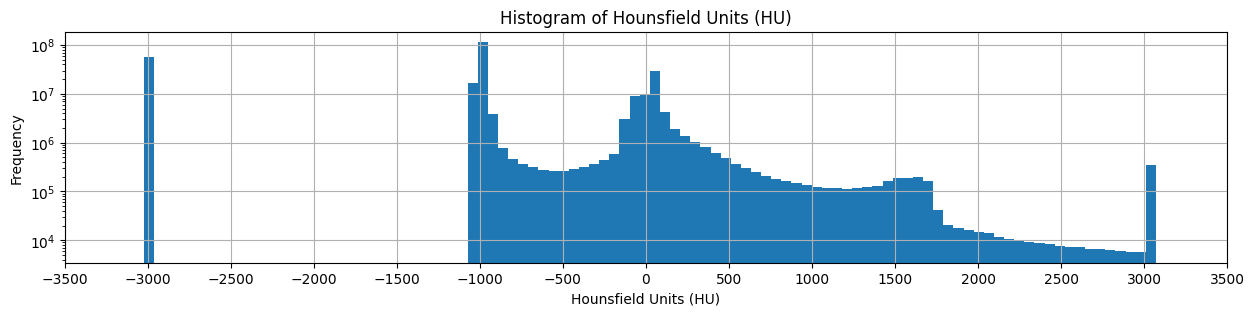

Min HU: -3024, Max HU: 3071


In [277]:
from lib.plothelpers import plot_histogram   

# Call the function with parameters ct_data and name
plot_histogram(ct_data, "Hounsfield Units (HU)", 500)

# Print min and max HU values 
print(f"Min HU: {ct_data.min()}, Max HU: {ct_data.max()}")

**Note**: The peak around -3000 HU is likely scan artifacts or noise, often from metal implants.

# Clipping and normalizing the values

Values below -700 are almost certainly just air. By removing them we can massively reduce the amount of data without reducing the quality of the data. 

For color mapping with three js we need also need to normalize these values to [0, 1]. 

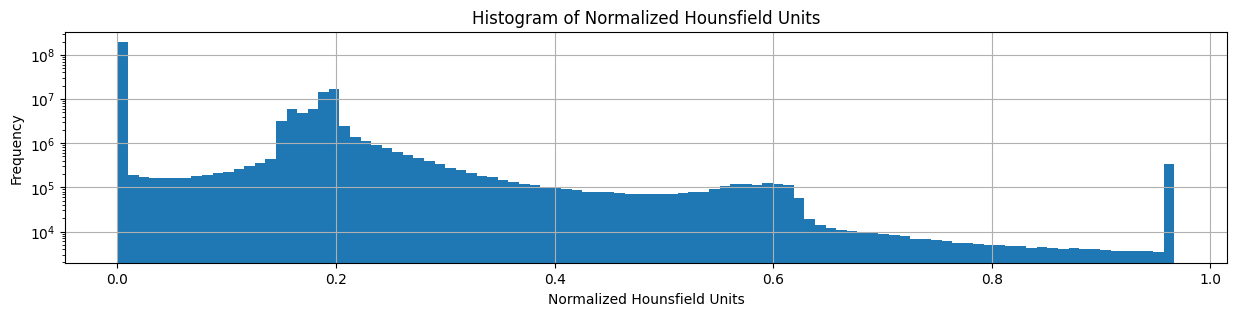

In [278]:
from lib.imageprocesing import clip_and_normalize

# Clip and normalize the data
ct_data_normalized = clip_and_normalize(ct_data, min_hu, max_hu)

# Plot the histogram of the normalized data
plot_histogram(ct_data_normalized, "Normalized Hounsfield Units")


# Subsample result to reduce file size

In [279]:
from lib.nrrdtools import save_ct_nrrd
from lib.imageprocesing import filter_and_subsample

# Usage example
ct_data_scaled = filter_and_subsample(ct_data_normalized, subsampling_factor=subsampling_factor, sigma=1)

Volume size before: (995, 512, 512), after: (332, 171, 171)


# Save as nrrd file

Save both the original the subsampled version. 
- The former for further processing of the normalized values
- The latter for web rendering of the 3D volume. 


In [280]:
import nrrd

save_ct_nrrd(filename_output_nrrd, ct_data_normalized)
if(generate_small_variant):
    save_ct_nrrd(filename_output_nrrd.replace(".nrrd", "_small.nrrd"), ct_data_scaled)

Saved as data/ct_scan_knee_postop.nrrd
Saved as data/ct_scan_knee_postop_small.nrrd


# Inspecting the generated header

In [281]:
from lib.nrrdtools import print_nrrd_header

# Load and print header for each NRRD file
print_nrrd_header(filename_output_nrrd)
print_nrrd_header(filename_stent_nrrd)

NRRD Header for data/ct_scan_knee_postop.nrrd:
type: float
dimension: 3
space: left-posterior-superior
sizes: [995 512 512]
space directions: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
endian: little
encoding: gzip
center of rotation: [0, 0, 0]

NRRD Header for data/stent.nrrd:
type: int16
dimension: 3
sizes: [256 128 128]
endian: little
encoding: gzip



# Visualizing data

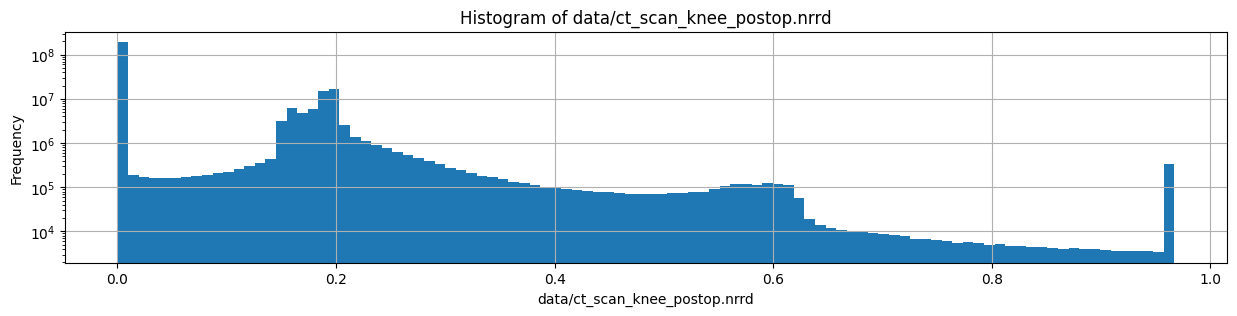

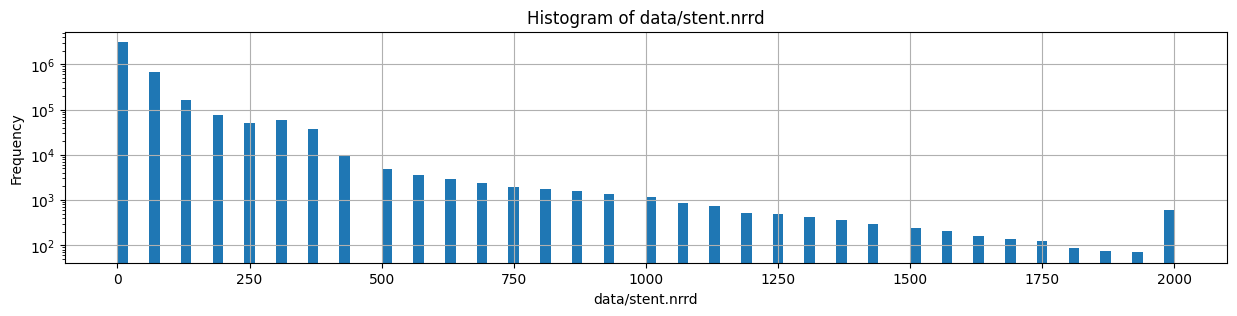

'data/ct_scan_knee_postop.nrrd'

In [282]:
def plot_histogram_from_nrrd_file(filename):
    """Reads an NRRD file and plots a histogram of its data values."""
    data, _ = nrrd.read(filename)
    plot_histogram(data.ravel(), filename, tick_interval=None)

# Plot histograms for each dataset
plot_histogram_from_nrrd_file(filename_output_nrrd)
plot_histogram_from_nrrd_file(filename_stent_nrrd)
filename_output_nrrd


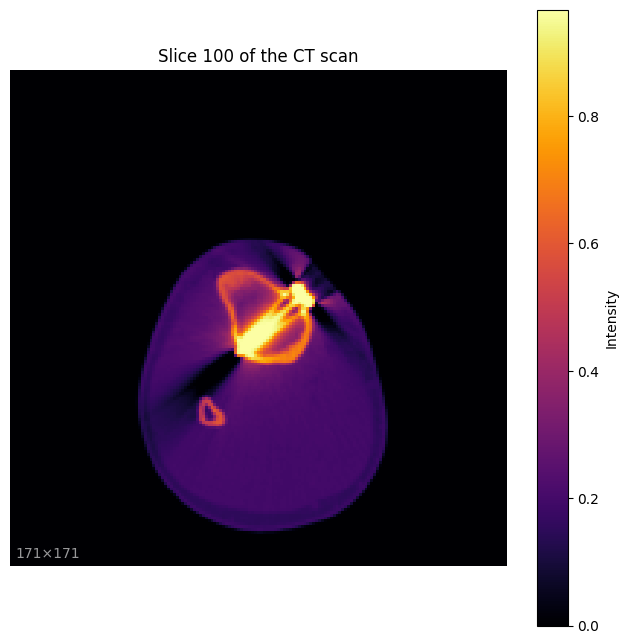

In [283]:
from lib.plothelpers import plot_image

# Select a slice
slice_index = 100
slice_data = ct_data_scaled[slice_index, :, :]  # Select the slice

plot_image(slice_data, title= f'Slice {slice_index} of the CT scan')